In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(stringr)
library(tidyr)
theme_set(theme_bw())
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



# Introduction

We look for isotype-specific, clade-specific, and clade-isotype-specific identity elements.

- **Isotype-specific** IDEs are verified by:
    - for the isotype in question, checking that 90% of the tRNAs for each clade contain the IDE
    - for the isotype in question, ensuring that the IDE exists at above 50% frequency for all species 
- **Clade-specific** IDEs are verified by:
    - for the clade in question, checking that 90% of the tRNAs for each isotype contain the IDE
    - ensuring that the IDE exists at above 50% frequency for all species and each isotype
- **Clade and isotype-specific** IDEs are verified by:
    - for the clade and isotype in question, checking that 90% of the tRNAs contain the IDE
    - for the isotype in question, ensuring that the IDE exists at above 50% frequency for all species
    
# Data wrangling
## Data import

In [2]:
identities = read.delim('identities.tsv', sep='\t', stringsAsFactors=FALSE)
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X20a', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

## Get frequencies

In [3]:
clade_iso_ac_freqs = identities %>%
  filter(quality & (!restrict | isotype == "iMet")) %>%
  select(match(c('clade', 'isotype', 'anticodon', positions), colnames(identities))) %>%
  gather(positions, bases, -clade, -isotype, -anticodon) %>%
  group_by(clade, isotype, anticodon, positions, bases) %>%
  tally() %>%
  group_by(clade, isotype, anticodon, positions) %>%
  mutate(freq=n) %>%
  group_by(clade, isotype, anticodon, positions) %>%
  summarize(A = sum(freq[bases == "A"]),
            C = sum(freq[bases == "C"]),
            G = sum(freq[bases == "G"]),
            U = sum(freq[bases == "U"]),
            Deletion = sum(freq[bases %in% c("-", ".")]), 
            Purine = sum(freq[bases %in% c("A", "G")]),
            Pyrimidine = sum(freq[bases %in% c("C", "U")]),
            Weak = sum(freq[bases %in% c("A", "U")]),
            Strong = sum(freq[bases %in% c("G", "C")]),
            Amino = sum(freq[bases %in% c("A", "C")]),
            Keto = sum(freq[bases %in% c("G", "U")]),
            B = sum(freq[bases %in% c("C", "G", "U")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            H = sum(freq[bases %in% c("A", "C", "U")]),
            V = sum(freq[bases %in% c("A", "C", "G")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            GC = sum(freq[bases == "G:C"]),
            AU = sum(freq[bases == "A:U"]),
            UA = sum(freq[bases == "U:A"]),
            CG = sum(freq[bases == "C:G"]),
            GU = sum(freq[bases == "G:U"]),
            UG = sum(freq[bases == "U:G"]),
            PairDeletion = sum(freq[bases == "-:-"]), 
            PurinePyrimidine = sum(freq[bases %in% c("A:U", "G:C")]),
            PyrimidinePurine = sum(freq[bases %in% c("U:A", "C:G")]),
            StrongPair = sum(freq[bases %in% c("G:C", "C:G")]),
            WeakPair = sum(freq[bases %in% c("A:U", "U:A")]),
            Wobble = sum(freq[bases %in% c("G:U", "U:G")]),
            Paired = sum(freq[bases %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G")]),
            Bulge = sum(freq[bases %in% c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U")]),
            Mismatched = sum(freq[bases %in% c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")])
            ) %>%
  mutate(total = A + B + Deletion + Paired + Mismatched + Bulge + PairDeletion) %>%
  melt(id.vars=c("clade", "isotype", "anticodon", "positions", "total")) %>%
  mutate(freq=value/total)

# Consensus IDEs

First, we'll quickly recapitulate the consensus IDEs. We can remove the IDEs that have high specificity (e.g. U8-A14), and we'll skip removal of IDEs with lower specificity (e.g., H54).

In [4]:
check_consensus_IDE = function(position, code) {
  codes = list(A = "A", C = "C", G = "G", U = "U", Deletion = c("-", "."), Purine = c("A", "G"), Pyrimidine = c("C", "U"), Weak = c("A", "U"), Strong = c("G", "C"), Amino = c("A", "C"), Keto = c("G", "U"), B = c("C", "G", "U"), D = c("A", "G", "U"), H = c("A", "C", "U"), V = c("A", "C", "G"), D = c("A", "G", "U"), GC =  "G:C", AU =  "A:U", UA =  "U:A", CG =  "C:G", GU =  "G:U", UG =  "U:G", PairDeletion =  "-:-", PurinePyrimidine = c("A:U", "G:C"), PyrimidinePurine = c("U:A", "C:G"), StrongPair = c("G:C", "C:G"), WeakPair = c("A:U", "U:A"), Wobble = c("G:U", "U:G"), Paired = c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge = c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched = c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")) 
  codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
  df = identities %>% select_('species', 'isotype', position) %>%
    group_by_('species', 'isotype') %>% 
    summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
               miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
    mutate(ubiquitous = match > miss)
  return(all(df$ubiquitous))
}

check_consensus_IDEs = Vectorize(check_consensus_IDE)

resolve_code = function(codes) {
  codes = unique(codes)
  x = c(A = all(codes %in% 'A'),
        C = all(codes %in% 'C'),
        G = all(codes %in% 'G'),
        U = all(codes %in% 'U'),
        Deletion = all(codes %in% 'Deletion'),
        Purine = all(codes %in% c('A', 'G', 'Purine')),
        Pyrimidine = all(codes %in% c('C', 'U', 'Pyrimidine')),
        Weak = all(codes %in% c('A', 'U', 'Weak')),
        Strong = all(codes %in% c('G', 'C', 'Strong')),
        Amino = all(codes %in% c('A', 'C', 'Amino')),
        Keto = all(codes %in% c('G', 'U', 'Keto')),
        B = all(codes %in% c('C', 'G', 'U', 'B', 'Strong', 'Pyrimidine', 'Keto')),
        D = all(codes %in% c('A', 'G', 'U', 'D', 'Purine', 'Weak', 'Keto')),
        H = all(codes %in% c('A', 'C', 'U', 'H', 'Amino', 'Weak', 'Pyrimidine')),
        V = all(codes %in% c('A', 'C', 'G', 'V', 'Amino', 'Purine', 'Strong')),
        GC = all(codes %in% 'GC'),
        AU = all(codes %in% 'AU'),
        UA = all(codes %in% 'UA'),
        CG = all(codes %in% 'CG'),
        GU = all(codes %in% 'GU'),
        UG = all(codes %in% 'UG'),
        PairDeletion = all(codes %in% 'PairDeletion'), 
        PurinePyrimidine = all(codes %in% c('AU', 'GC', 'PurinePyrimidine')),
        PyrimidinePurine = all(codes %in% c('UA', 'CG', 'PyrimidinePurine')),
        StrongPair = all(codes %in% c('GC', 'CG', 'StrongPair')),
        WeakPair = all(codes %in% c('AU', 'UA', 'WeakPair')),
        Wobble = all(codes %in% c('GU', 'UG', 'Wobble')),
        Paired = all(codes %in% c('AU', 'UA', 'CG', 'GC', 'GU', 'UG', 'Paired', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'Wobble')),
        Bulge = all(codes %in% 'Bulge'),
        Mismatched = all(codes %in% c('AA', 'GG', 'CC', 'UU', 'AG', 'AC', 'CA', 'CU', 'GA', 'UC', 'Mismatched', 'Paired', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'Wobble')))
  return(names(x[which(x)]))
}

In [5]:
consensus = clade_iso_ac_freqs %>% 
  group_by(isotype, positions, clade, variable) %>% # remove duplicates
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>%
  arrange(freq) %>%
  group_by(isotype, clade, positions) %>%
  filter(row_number(freq) == 1) %>%
  group_by(positions) %>% 
  mutate(best_code = resolve_code(variable)[1]) %>%
  summarize(hifreq = length(unique(best_code)) == 1 & n() == 147 & !is.na(best_code[1]), variable=best_code[1]) %>%
  filter(hifreq) %>%
  select(positions, variable) %>%
  mutate(ubiquitous = check_consensus_IDEs(positions, variable)) %>%
  filter(ubiquitous)

consensus

,positions,variable,ubiquitous
1,X14,A,TRUE
2,X19,G,TRUE
3,X19.56,GC,TRUE
4,X33,Pyrimidine,TRUE
5,X38,H,TRUE
6,X54,H,TRUE
7,X55,Pyrimidine,TRUE
8,X56,C,TRUE
9,X57,Purine,TRUE
10,X8,U,TRUE


# Isotype-specific IDEs

In [28]:
check_isotype_IDE = function(position, isotype, code) {
  codes = list(A = "A", C = "C", G = "G", U = "U", Deletion = c("-", "."), Purine = c("A", "G"), Pyrimidine = c("C", "U"), Weak = c("A", "U"), Strong = c("G", "C"), Amino = c("A", "C"), Keto = c("G", "U"), B = c("C", "G", "U"), D = c("A", "G", "U"), H = c("A", "C", "U"), V = c("A", "C", "G"), D = c("A", "G", "U"), GC =  "G:C", AU =  "A:U", UA =  "U:A", CG =  "C:G", GU =  "G:U", UG =  "U:G", PairDeletion =  "-:-", PurinePyrimidine = c("A:U", "G:C"), PyrimidinePurine = c("U:A", "C:G"), StrongPair = c("G:C", "C:G"), WeakPair = c("A:U", "U:A"), Wobble = c("G:U", "U:G"), Paired = c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge = c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched = c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")) 
  codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
  df = identities %>%
    select_('species', 'isotype', position) %>%
    filter_(paste0("isotype == '", isotype, "'")) %>%
    group_by_('species') %>% 
    summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
               miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
    mutate(ubiquitous = match > miss)
  return(all(df$ubiquitous))
}

check_isotype_IDEs = Vectorize(check_isotype_IDE)

In [33]:
isotype_specific = clade_iso_ac_freqs %>%
  filter(!(positions %in% consensus$positions)) %>%
  group_by(isotype, positions, clade, variable) %>% # remove duplicates
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>%
  arrange(freq) %>%
  group_by(isotype, clade, positions) %>%
  filter(row_number(freq) == 1) %>%
  group_by(isotype, positions) %>% 
  mutate(best_code = resolve_code(variable)[1]) %>%
  summarize(hifreq = length(unique(best_code)) == 1 & n() == 7 & !is.na(best_code[1]), variable=best_code[1]) %>%
  filter(hifreq) %>%
  select(isotype, positions, variable) %>%
  mutate(ubiquitous = check_isotype_IDEs(positions, isotype, variable)) %>%
  filter(ubiquitous)

In [35]:
nrow(isotype_specific)

[1] 512

There are 512 isotype-specific IDEs. I'll summarize in a couple of ways.

This first plot shows the number of IDEs that are specific to $x$ number of isotypes. So the first bar shows that there are 52 position + IDE combinations belonging to only one isotype. Which brings up the question - what is an isotype-specific element? What if multiple isotypes share an identity element? This plot shows the spread of how many isotypes share how many IDEs.

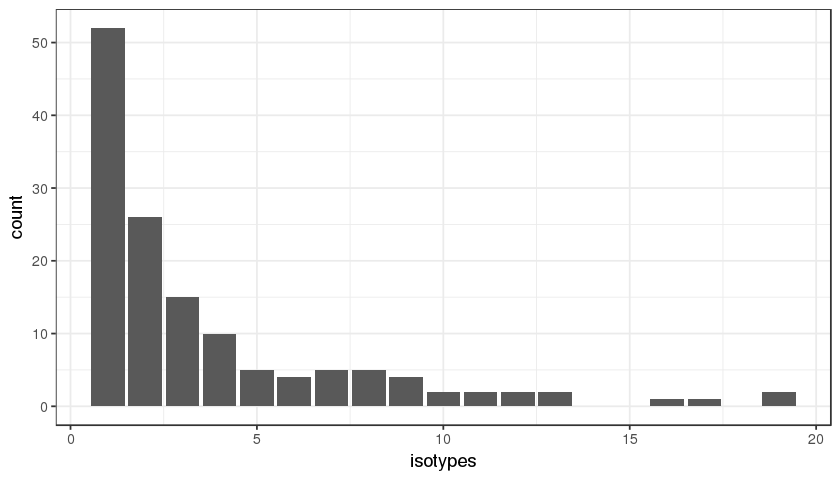

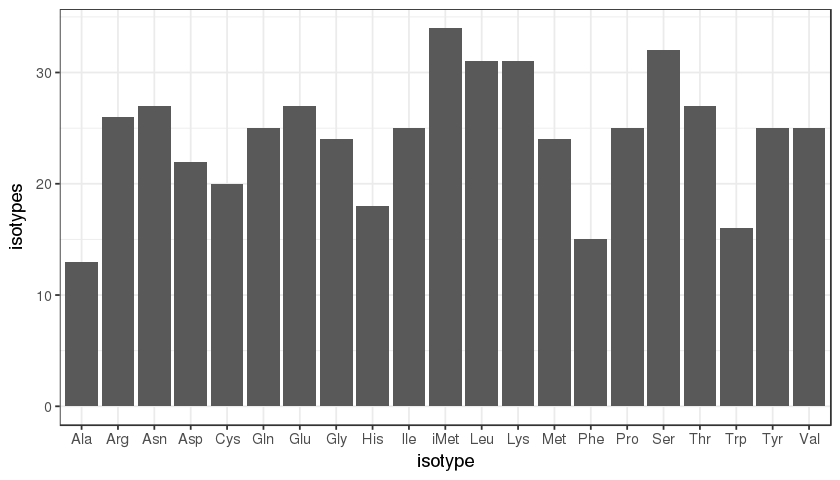

In [45]:
isotype_specific %>% group_by(positions, variable) %>%
  summarize(isotypes = n()) %>%
  ggplot() + geom_bar(aes(x=isotypes))

isotype_specific %>% group_by(isotype) %>%
  summarize(isotypes = n()) %>%
  ggplot() + geom_bar(aes(x=isotype, y=isotypes), stat='identity')

The second plot shows the number of IDEs per isotype. This is higher than I thought, since it also excludes consensus elements. 